### AI-Powered Strategy

## Oanda API

In [ ]:
!pip install --upgrade git+https://github.com/yhilpisch/tpqoa.git
import tpqoa
import numpy as np
import pandas as pd
!pip install ta
import ta
import pdb;

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/yhilpisch/tpqoa.git to /tmp/pip-req-build-_1j1ylc1
  Running command git clone --filter=blob:none --quiet https://github.com/yhilpisch/tpqoa.git /tmp/pip-req-build-_1j1ylc1
  Resolved https://github.com/yhilpisch/tpqoa.git to commit f47a1ffddd2b2684c7e1569df6210b98dbe4e701
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.1 MB/s eta 0:00:00
  Created wheel for tpqoa: filename=tpqoa-0.0.55-py3-none-any.whl size=10908 sha256=aa073e64e0af6205e21d481c642a9535a28665a302afac7b2ebe72587788b29b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbs4n_ok/wheels/25/02/45/e375e857935fa5ecce662529ffe8a6c80d3857356999406a13
  Created wheel for v20: filename=v20-3.0.25.0-py3-none-any.whl size=85779 sha256

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
oanda = tpqoa.tpqoa('oanda_.cfg')

## The Data

In [ ]:
%%time
data = oanda.get_history(
    instrument='EUR_USD',
    start='2023-05-9',
    end='2023-05-10',
    granularity='S5',
    price='M'
)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13994 entries, 2023-05-09 00:00:00 to 2023-05-10 00:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         13994 non-null  float64
 1   h         13994 non-null  float64
 2   l         13994 non-null  float64
 3   c         13994 non-null  float64
 4   volume    13994 non-null  int64  
 5   complete  13994 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 669.6 KB
CPU times: user 700 ms, sys: 10.6 ms, total: 710 ms
Wall time: 1.7 s


In [ ]:
data['r'] = np.log(data['c'] / data['c'].shift(-1))

In [ ]:
data['d'] = np.sign(data['r'])

## The Strategy

In [ ]:
lags = 3

In [ ]:
cols = list()
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['r'].shift(lag)
    cols.append(col)

In [ ]:
data.head()

,o,h,l,c,volume,complete,r,d,lag_1,lag_2,lag_3
time,,,,,,,,,,,
2023-05-09 00:00:00,1.09966,1.09966,1.09962,1.09964,9,True,-0.000064,-1.0,NaN,NaN,NaN
2023-05-09 00:00:05,1.09966,1.09971,1.09966,1.09971,5,True,0.000064,1.0,-0.000064,NaN,NaN
2023-05-09 00:00:10,1.09969,1.09971,1.09964,1.09964,7,True,-0.000055,-1.0,0.000064,-0.000064,NaN
2023-05-09 00:00:15,1.09968,1.09970,1.09968,1.09970,4,True,0.000000,0.0,-0.000055,0.000064,-0.000064
2023-05-09 00:00:20,1.09970,1.09970,1.09970,1.09970,6,True,-0.000018,-1.0,0.000000,-0.000055,0.000064


In [ ]:
data.dropna(inplace=True)
b=2.5
z=2

In [ ]:
data['d'] = data['d'].astype(int)

## Train-Test Split

In [ ]:
split = int(len(data) * 0.8)
split

11192

In [ ]:
train = data.iloc[:split].copy()

In [ ]:
mu, std = train.mean(), train.std()

In [ ]:
train_ = (train - mu) / std

In [ ]:
test = data.iloc[split:].copy()

In [ ]:
test_ = (test - mu) / std

## Training of the Model

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
model = MLPClassifier(hidden_layer_sizes=[24],
                      shuffle=False,
                      max_iter=500)

In [ ]:
model.fit(train_[cols], train['d'])

MLPClassifier(hidden_layer_sizes=[24], max_iter=500, shuffle=False)

In [ ]:
accuracy_score(train['d'], model.predict(train_[cols]))*b

0.9656451036454611

## Testing of the Model

In [ ]:
test['p'] = model.predict(test_[cols])

In [ ]:
accuracy_score(test['d'], test['p'])*z

0.8205861329521087

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

r    0.999526
s    1.002401
dtype: float64

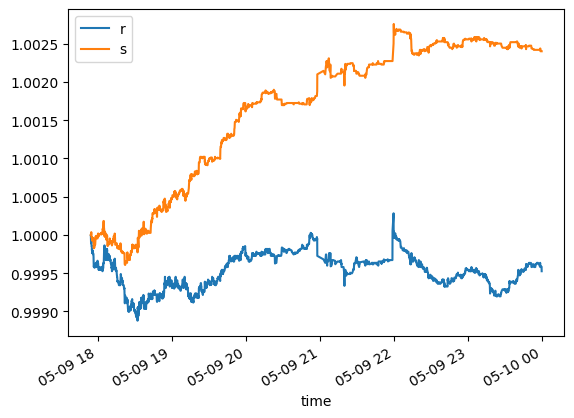

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot();

## Trading Code

In [ ]:
oanda.on_success??

In [ ]:
oanda.stream_data('EUR_USD', stop=10)  # streaming data

2023-05-12T20:58:00.339178780Z 1.08486 1.08511


In [ ]:
oanda.create_order('EUR_USD', units=1000)  # opening long position

In [ ]:
oanda.create_order('EUR_USD', units=-1000)  # closing long position

## Simple Deployment

In [ ]:
model.predict(test[cols])[-1]

In [ ]:
class MLPTrader(tpqoa.tpqoa):
    def __init__(self, config_file,model, momentum, sma_period, rsi_period, rsi_upper, rsi_lower):
        super(MLPTrader, self).__init__(config_file)
        self.model = model
        self.min_length = lags
        self.position = 0
        self.units = 100000
        self.tick_data = pd.DataFrame()
        self.sentiment = None
        self.sentiment_analyzer = SentimentIntensityAnalyzer()

    def get_sentiment(self, text):
        sentiment = self.sentiment_analyzer.polarity_scores(text)
        return sentiment['compound']

    def fetch_news_sentiment(self):
        url = "https://www.bbc.com/news"  # Replace with the actual URL of the news website
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        news_articles = soup.find_all('div', class_='news-article')  # Replace with the appropriate HTML tags and classes to locate the news articles
        a=1
        sentiment_scores = []
        for article in news_articles:
            headline = article.find('h2').text.strip()  # Replace with the appropriate HTML tags to locate the headline
            content = article.find('p').text.strip()  # Replace with the appropriate HTML tags to locate the content
            text = f"{headline}. {content}"
            sentiment = self.get_sentiment(text)
            sentiment_scores.append(sentiment)


            average_sentiment = sum(sentiment_scores) / a
        return average_sentiment

    def on_success(self, time, bid, ask):
        print(self.ticks, end=' ')
        df = pd.DataFrame({'b': bid, 'a': ask, 'm': (ask + bid) / 2},
                         index=[pd.Timestamp(time).tz_localize(tz=None)])
        print(df)
        self.tick_data = pd.concat((self.tick_data, df))
        # resampling the tick data to 5 second intervals
        self.data = self.tick_data.resample('5s', label='right').last().ffill()
        self.data['r'] = np.log(self.data['m'] / self.data['m'].shift(1))
        self.data.dropna(inplace=True)

        if len(self.data) > self.min_length:
            self.min_length += 1
            prediction = self.model.predict(
                self.data['m'].iloc[-lags-1:-1].values.reshape(1, -1))
            print(prediction)
            # checking for long signal
            if  prediction == 1 and self.position in [0, -1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=(1 - self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING LONG ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = 1
            # checking for short signal
            if  prediction == -1 and self.position in [0, 1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=-(1 + self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING SHORT ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = -1
            # updating sentiment data
            if self.sentiment_analyzer is not None:
                sentiment = self.fetch_news_sentiment()
                print(sentiment)
                sentiment_threshold = 0.5
                if self.sentiment > sentiment_threshold and self.sentiment!=0 and self.position in [0, -1]:
                    o = oanda.create_order(self.stream_instrument,
                                       units=(1 - self.position) * self.units,
                                       suppress=True, ret=True)
                    print('\n*** GOING LONG (sentiment) ***')
                    self.print_transactions(tid=int(o['id']) - 1)
                    self.position = 1
                elif self.sentiment < -sentiment_threshold and self.sentiment!=0 and self.position in [0, 1]:
                    o = oanda.create_order(self.stream_instrument,
                                       units=-(1 + self.position) * self.units,
                                       suppress=True, ret=True)
                    print('\n*** GOING SHORT (sentiment) ***')
                    self.print_transactions(tid=int(o['id']) - 1)
                    self.position = -1

In [ ]:
mt = MLPTrader('oanda_.cfg',model,momentum=10, sma_period=20, rsi_period=14, rsi_upper=70, rsi_lower=30)
mt.stream_data('EUR_USD', stop=150)

In [ ]:
from pprint import pprint
o = mt.create_order('EUR_USD', units=-mt.position * mt.units,
                    suppress=True, ret=True)
print('\n*** POSITION CLOSED ***')
mt.print_transactions(tid=int(o['id']) - 1)
print('\n')
pprint(o)